## Installing Python Packages

In [1]:
# This notebook is for runpod

In [17]:
#!pip install --upgrade --quiet transformers bitsandbytes accelerate evaluate peft trl scikit-learn datasets

In [2]:
PUSH_MODEL_ID = "shahzira/appendix-model"

## Loading and Processing the Dataset

In [3]:
import os
import shutil
from tqdm import tqdm

In [4]:
from datasets import load_dataset, DatasetDict

# Paths to the already processed PNG folders
data_dir = r"/workspace/MedGemma/Test_folder"
train_dir = f"{data_dir}/Training_data_png"
val_dir = f"{data_dir}/Validation_data_png"
test_dir = f"{data_dir}/Test_data_png"

# Load each split individually
train_ds = load_dataset("imagefolder", data_dir=train_dir, split="train")
val_ds = load_dataset("imagefolder", data_dir=val_dir, split="train")      # Note: 'train' here means all images in that folder
test_ds = load_dataset("imagefolder", data_dir=test_dir, split="train")

# Combine into a DatasetDict
data = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(data)


Resolving data files:   0%|          | 0/435 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/109 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/137 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 435
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 137
    })
})


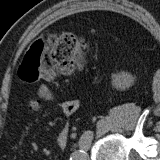

In [5]:
# Display the first image (as a PIL object)
data["train"][0]["image"]

In [6]:
PATHOLOGY_CLASSES = data["train"].features["label"].names
print("Detected classes:", PATHOLOGY_CLASSES)

Detected classes: ['negative', 'positive']


In [7]:
PATHOLOGY_CLASSES = ['A: normal', 'B: appendix']

options = "\n".join(PATHOLOGY_CLASSES)
PROMPT = f"What is the most likely type of pathology shown in the CT image?\n{options}"


In [8]:
def format_data(example: dict[str, any]) -> dict[str, any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": PATHOLOGY_CLASSES[example["label"]],
                },
            ],
        },
    ]
    return example

# Apply the formatting to the dataset
formatted_data = data.map(format_data)

# Display a sample formatted data point
formatted_data["train"][0]["messages"]


Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

[{'content': [{'text': None, 'type': 'image'},
   {'text': 'What is the most likely type of pathology shown in the CT image?\nA: normal\nB: appendix',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'text': 'A: normal', 'type': 'text'}], 'role': 'assistant'}]

In [10]:
formatted_data["train"][90]["messages"]

[{'content': [{'text': None, 'type': 'image'},
   {'text': 'What is the most likely type of pathology shown in the CT image?\nA: normal\nB: appendix',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'text': 'A: normal', 'type': 'text'}], 'role': 'assistant'}]

## Loading the Model and Tokenizer

In [11]:
from huggingface_hub import whoami
print(whoami())

{'type': 'user', 'id': '66a02788db7879d457bc85a7', 'name': 'shahzira', 'fullname': 'iram shahzadi', 'isPro': False, 'avatarUrl': '/avatars/831a6b0a8b6f301952da5b841abc648f.svg', 'orgs': [{'type': 'org', 'id': '6877ccbea49a907a8e8e2f76', 'name': 'IraBid-Medical-AI', 'fullname': 'IraBid Medical AI', 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/603945d6db430f160dced222/UvPH75zsMtl3uEJ_HK2i2.png', 'isEnterprise': False}], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'Medgemma_runpod', 'role': 'fineGrained', 'createdAt': '2025-07-15T10:43:21.067Z', 'fineGrained': {'canReadGatedRepos': True, 'global': [], 'scoped': [{'entity': {'_id': '66a02788db7879d457bc85a7', 'type': 'user', 'name': 'shahzira'}, 'permissions': ['repo.content.read', 'repo.write']}]}}}}


In [12]:
from huggingface_hub import HfApi

api = HfApi()
try:
    info = api.model_info("google/medgemma-4b-it")
    print("Access granted!")
except Exception as e:
    print(f"Access denied: {e}")

Access granted!


In [13]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

## Setting up the Model

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [ ]:
def collate_fn(examples: list[dict[str, any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["image"]])
        texts.append(
            processor.apply_chat_template(
                example["messages"], add_generation_prompt=False, tokenize=False
            ).strip()
        )

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch


In [ ]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="medgemma-brain-cancer",            
    num_train_epochs=1,                       
    per_device_train_batch_size=8,                           
    per_device_eval_batch_size=8,                            
    gradient_accumulation_steps=8,                           
    gradient_checkpointing=True,                             
    optim="adamw_torch_fused",                               
    logging_steps=0.1,                                        
    save_strategy="epoch",                                   
    eval_strategy="steps",                                   
    eval_steps=0.1,                                           
    learning_rate=2e-4,                             
    bf16=True,                                               
    max_grad_norm=0.3,                                       
    warmup_ratio=0.03,                                       
    lr_scheduler_type="linear",                              
    push_to_hub=True,                                        
    report_to="none",
    gradient_checkpointing_kwargs={"use_reentrant": False},  
    dataset_kwargs={"skip_prepare_dataset": True},           
    remove_unused_columns = False,                           
    label_names=["labels"],                                  
)

In [ ]:
import peft
from peft import PeftConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=formatted_data["train"],
    eval_dataset=formatted_data["validation"].shuffle().select(range(50)), 
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

## Model Training

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()
processor.save_pretrained(PUSH_MODEL_ID)
processor.push_to_hub(PUSH_MODEL_ID)

## Model Evaluation

In [ ]:
# Clear memory to avoid OOM errors
import torch
del model
del trainer
torch.cuda.empty_cache()

In [ ]:

# Import libraries
from transformers import AutoModelForImageTextToText, AutoProcessor, GenerationConfig
from datasets import ClassLabel
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
from typing import List, Any, Callable


### Setting up for model testing

In [ ]:

# Define function to format data
def format_test_data(example: dict[str, any]) -> dict[str, any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": PROMPT},
            ],
        },
    ]
    return example

In [ ]:
# Define paths (from your original code)
data_dir = r"E:\Appendicitis_final_materials\Data\Imaging\Repeat2_Fold3_data_cubic"
train_dir = f"{data_dir}/flattened_training_data"
val_dir = f"{data_dir}/flattened_validation_data"
test_dir = f"{data_dir}/flattened_test_data"

In [ ]:
# Format all datasets and cast labels becasue we want to apply trained model on all datasets
data_splits = ["train", "validation", "test"]
formatted_data = {}
for split in data_splits:
    formatted_data[split] = data[split].map(format_test_data)
    formatted_data[split] = formatted_data[split].cast_column(
        "label", ClassLabel(names=PATHOLOGY_CLASSES)
    )


# Define label feature and alternative labels
LABEL_FEATURE = formatted_data["test"].features["label"]
ALT_LABELS = dict([(label, f"({label.replace(': ', ') ')}") for label in PATHOLOGY_CLASSES])

In [ ]:
#setting up image paths to be used in excel export
image_paths = {
    split: [f["path"] for f in data[split].data_files]
    for split in data_splits
}

In [ ]:
# Postprocess function
def postprocess(prediction, do_full_match: bool = False) -> int:
    if isinstance(prediction, str):
        response_text = prediction
    else:
        response_text = prediction[0]["generated_text"]

    if do_full_match:
        try:
            return LABEL_FEATURE.str2int(response_text)
        except ValueError:
            return -1

    for label in PATHOLOGY_CLASSES:
        if label in response_text or ALT_LABELS[label] in response_text:
            return LABEL_FEATURE.str2int(label)

    return -1

In [ ]:
# Batch prediction function
def batch_predict(
    prompts,
    images,
    model,
    processor,
    postprocess,
    *,
    batch_size=64,
    device="cuda",
    dtype=torch.bfloat16,
    **gen_kwargs
):
    preds = []
    for i in range(0, len(prompts), batch_size):
        texts = prompts[i : i + batch_size]
        imgs = [[img] for img in images[i : i + batch_size]]
        enc = processor(text=texts, images=imgs, padding=True, return_tensors="pt").to(
            device, dtype=dtype
        )
        lens = enc["attention_mask"].sum(dim=1)
        with torch.inference_mode():
            out = model.generate(
                **enc,
                disable_compile=True,
                **gen_kwargs
            )
        for seq, ln in zip(out, lens):
            ans = processor.decode(seq[ln:], skip_special_tokens=True)
            preds.append(postprocess(ans))
    return preds

# Compute metrics including AUC, Sensitivity, and Specificity
def compute_metrics(predictions: list[int], references: list[int]) -> dict[str, float]:
    metrics = {}
    # Load standard metrics
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    
    # Compute accuracy and F1
    metrics.update(accuracy_metric.compute(predictions=predictions, references=references))
    metrics.update(f1_metric.compute(predictions=predictions, references=references, average="weighted"))
    
    
    # Compute Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(references, predictions, labels=[0, 1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics["sensitivity"] = sensitivity
    metrics["specificity"] = specificity
    
    return metrics

# Save predictions to Excel
def save_predictions_to_excel(predictions: list[int], dataset, image_paths: list[str], split_name: str, model_type: str):
    pred_labels = [PATHOLOGY_CLASSES[pred] if pred != -1 else "unknown" for pred in predictions]
    original_labels = [PATHOLOGY_CLASSES[label] for label in dataset["label"]]
    df = pd.DataFrame({
        "Image_Path": image_paths,
        "Prediction": pred_labels,
        "Original_Label": original_labels
    })
    output_file = f"{model_type}_predictions_{split_name}.xlsx"
    df.to_excel(output_file, index=False)
    print(f"Saved {model_type} predictions for {split_name} split to {output_file}")

In [ ]:
#Cell 3: Base Model Evaluation
#This cell loads the base model, generates predictions for all splits, and stores them for later use.

# Model kwargs
model_kwargs = dict(
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Load base model
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)

# Configure generation
gen_cfg = GenerationConfig.from_pretrained(model_id)
gen_cfg.update(
    do_sample=False,
    top_k=None,
    top_p=None,
    cache_implementation="dynamic"
)
model.generation_config = gen_cfg

# Load processor
processor = AutoProcessor.from_pretrained(model_id)
tok = processor.tokenizer
model.config.pad_token_id = tok.pad_token_id
model.generation_config.pad_token_id = tok.pad_token_id

# Generate predictions for all splits
base_predictions = {}
for split in data_splits:
    prompts = [processor.apply_chat_template(c, add_generation_prompt=True, tokenize=False) 
               for c in formatted_data[split]["messages"]]
    images = formatted_data[split]["image"]
    
    predictions = batch_predict(
        model=model,
        processor=processor,
        prompts=prompts,
        images=images,
        batch_size=64,
        max_new_tokens=40,
        postprocess=postprocess
    )
    base_predictions[split] = predictions
    print(f"Completed base model predictions for {split} split: {len(predictions)} samples")

# Clear memory
del model
torch.cuda.empty_cache()

In [ ]:
#Cell 4: Base Model Metrics and Excel Saving
#This cell computes metrics and saves predictions to Excel for the base model.
# Compute metrics and save predictions for base model
base_metrics = {}
for split in data_splits:
    references = formatted_data[split]["label"]
    predictions = base_predictions[split]
    base_metrics[split] = compute_metrics(predictions, references)
    print(f"Base model metrics for {split} split: {base_metrics[split]}")
    save_predictions_to_excel(predictions, formatted_data[split], image_paths[split], split, "base_model")

In [ ]:
#Cell 5: Fine-Tuned Model Evaluation
#This cell loads the fine-tuned model and generates predictions for all splits.
# Load fine-tuned model's processor first to avoid OOM errors
processor = AutoProcessor.from_pretrained(args.output_dir)
tok = processor.tokenizer

# Load fine-tuned model
model = AutoModelForImageTextToText.from_pretrained(args.output_dir, **model_kwargs)
model.generation_config = gen_cfg
model.config.pad_token_id = tok.pad_token_id
model.generation_config.pad_token_id = tok.pad_token_id

# Generate predictions for all splits
fine_tuned_predictions = {}
for split in data_splits:
    prompts = [processor.apply_chat_template(c, add_generation_prompt=True, tokenize=False) 
               for c in formatted_data[split]["messages"]]
    images = formatted_data[split]["image"]
    
    predictions = batch_predict(
        model=model,
        processor=processor,
        prompts=prompts,
        images=images,
        batch_size=64,
        max_new_tokens=40,
        postprocess=postprocess
    )
    fine_tuned_predictions[split] = predictions
    print(f"Completed fine-tuned model predictions for {split} split: {len(predictions)} samples")

# Clear memory
del model
torch.cuda.empty_cache()

In [ ]:
#Cell 6: Fine-Tuned Model Metrics and Excel Saving
#This cell computes metrics and saves predictions to Excel for the fine-tuned model.
# Compute metrics and save predictions for fine-tuned model
fine_tuned_metrics = {}
for split in data_splits:
    references = formatted_data[ "split"]]["label"]
    predictions = fine_tuned_predictions[split]
    fine_tuned_metrics[split] = compute_metrics(predictions, references)
    print(f"Fine-tuned model metrics for {split} split: {fine_tuned_metrics[split]}")
    save_predictions_to_excel(predictions, formatted_data[split], image_paths[split], split, "fine_tuned_model")